<a href="https://colab.research.google.com/github/ArushiPuri15/AgroScanAi/blob/main/agroscanai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
import os

HOME = os.getcwd()
print("HOME:", HOME)

Mon Feb 10 06:11:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .
!pip install -q -U google-generativeai

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 463 (delta 176), reused 137 (delta 137), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 7.93 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━

In [3]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xqoimrav
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xqoimrav
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=45b969eca9c4dd1d100d7eec73fd831b09c4c1c6c693ca75ef8cdc50725b4d53
  Stored in directory: /tmp/pip-ephem-wheel-cache-_a430y5e/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [4]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

import os

GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH))

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")
print(GROUNDING_DINO_CHECKPOINT_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH))

%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0
/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content
/content/weights
/content/weights/groundingdino_swint_ogc.pth ; exist: True
/content
/content/weights


In [5]:
import pathlib
import textwrap

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown


def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [6]:
import os
import torch

SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(SAM_CHECKPOINT_PATH, "; exist:", os.path.isfile(SAM_CHECKPOINT_PATH))

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)
SAM_ENCODER_VERSION = "vit_h"

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

import numpy as np

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

/content/weights/sam_vit_h_4b8939.pth ; exist: True
/content/GroundingDINO


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/content/GroundingDINO/groundingdino/util/inference.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
/

In [7]:
SOURCE_IMAGE_PATH = "/content/farm.jpg"
CLASSES = ['all plants']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1044: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/content/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocas

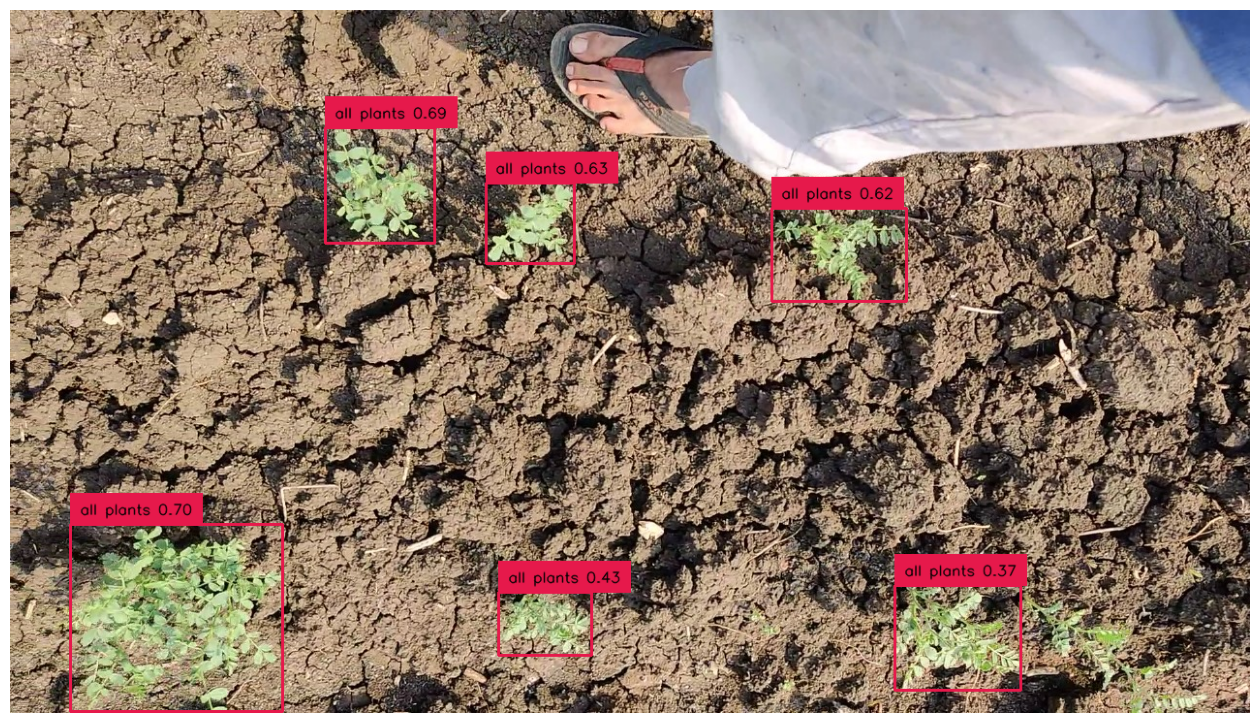

In [9]:
import cv2
import supervision as sv
import torch

# load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=CLASSES,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

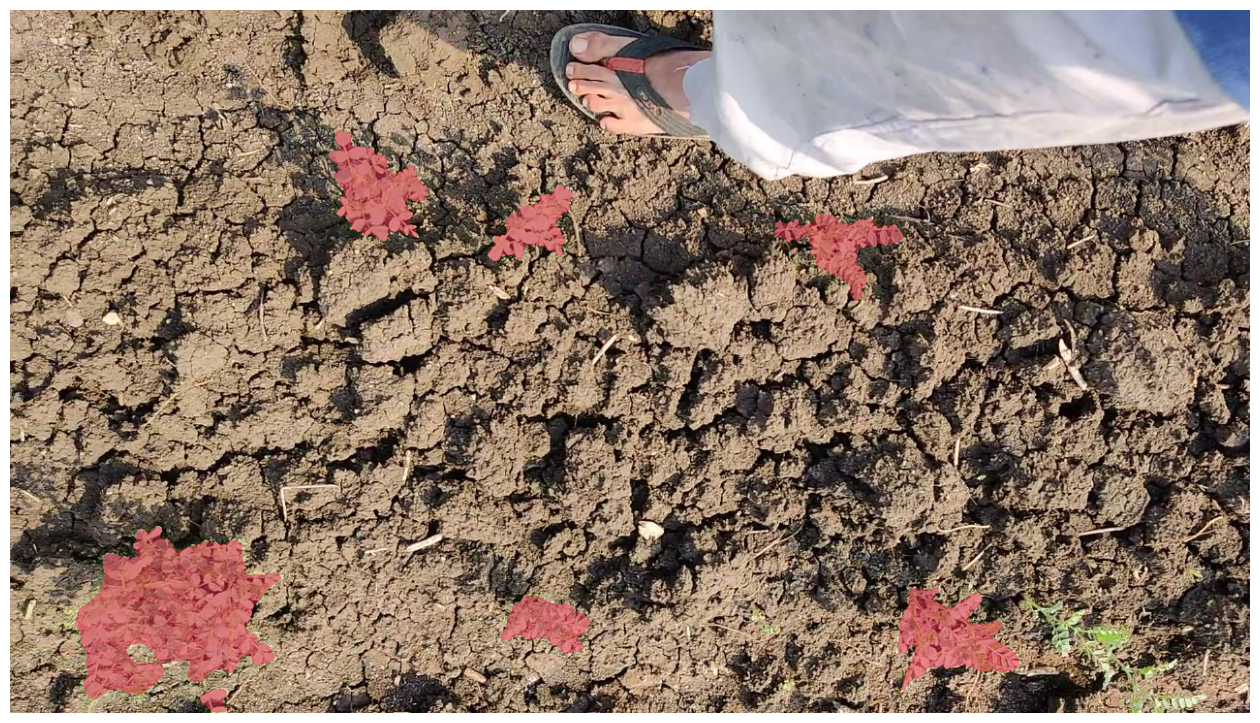

In [10]:
import cv2
import matplotlib.pyplot as plt

# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()

labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
# annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
gray_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2GRAY)

%matplotlib inline
sv.plot_image(annotated_image, (16, 16))


In [11]:
import cv2
frame = cv2.imread(SOURCE_IMAGE_PATH)

n=1
detections = grounding_dino_model.predict_with_classes(
            image=frame,
            classes=CLASSES,
            box_threshold=BOX_TRESHOLD,
            text_threshold=TEXT_TRESHOLD
        )
        # convert detections to masks
detections.mask = segment(
            sam_predictor=sam_predictor,
            image=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
            xyxy=detections.xyxy
        )
objct = 0

for obj in detections.mask:
  for rows in obj:
    objct += np.sum(rows)

density = (objct/(1920*1090))*100
# density_list.append(density)
print(f"frame:{n} ,density:{density}")

frame:1 ,density:2.3523509174311927


In [12]:
import cv2
import supervision as sv
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

CLASSES = ['all plants']
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

density_list = []

# Function to process video frames
def process_video(video_path):
    n = 1
    # Open video capture
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Break the loop if no more frames

        # Perform object detection on the current frame with Grounding Dino
        detections = grounding_dino_model.predict_with_classes(
                    image=frame,
                    classes=CLASSES,
                    box_threshold=BOX_TRESHOLD,
                    text_threshold=TEXT_TRESHOLD
                )

        # convert detected bounding boxes to masks with SAM model
        detections.mask = segment(
                    sam_predictor=sam_predictor,
                    image=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),
                    xyxy=detections.xyxy
                )

        # # annotate image with detections
        # box_annotator = sv.BoxAnnotator()
        # mask_annotator = sv.MaskAnnotator()

        # labels = [
        #     f"{CLASSES[class_id]} {confidence:0.2f}"
        #     for _, _, confidence, class_id, _
        #     in detections]

        # annotated_image = mask_annotator.annotate(scene=frame.copy(), detections=detections)
        # # annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
        # gray_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2GRAY)

        # %matplotlib inline
        # sv.plot_image(annotated_image, (16, 16))

        objct = 0

        for obj in detections.mask:
          for rows in obj:
            objct += np.sum(rows)

        density = (objct/(1920*1090))*100
        density_list.append(density)
        print(f"frame:{n}\tdensity:{density}")
        n+=1

# Specify the path to the video file
VIDEO_PATH = '/content/demo farm.mp4'

# Call the function to process the video
process_video(VIDEO_PATH)

frame:1	density:8.955753058103975
frame:2	density:9.50530389908257
frame:3	density:7.822104357798166
frame:4	density:9.128201452599388
frame:5	density:8.985187308868502
frame:6	density:8.615443425076453
frame:7	density:8.567469418960243
frame:8	density:8.424120795107033
frame:9	density:8.1465500764526
frame:10	density:8.627054663608563
frame:11	density:8.384365443425077
frame:12	density:8.46535741590214
frame:13	density:8.50062117737003
frame:14	density:8.390147171253822
frame:15	density:8.278621941896025
frame:16	density:7.992306957186544
frame:17	density:7.834910168195719
frame:18	density:8.500573394495413
frame:19	density:9.351204128440367
frame:20	density:8.89506880733945
frame:21	density:9.14205848623853
frame:22	density:8.954319571865444
frame:23	density:10.697438837920489
frame:24	density:7.817947247706422
frame:25	density:5.420919342507646
frame:26	density:7.2880351681957185
frame:27	density:7.543577981651377
frame:28	density:6.949206804281345
frame:29	density:95.725248470948
f

In [13]:
refined_list = []

for i in density_list:
  if i > 30:
    refined_list.append(abs(100-i))
  else:
    refined_list.append(i)

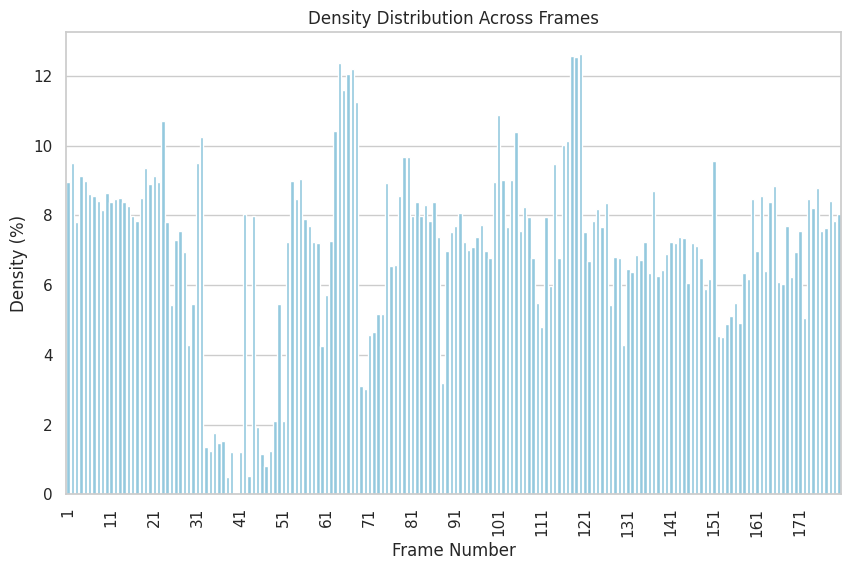

<Figure size 640x480 with 0 Axes>

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming density_list contains your density values
# density_list = [density_frame1, density_frame2, ..., density_frame180]

# Generate x-axis values for each frame
frame_numbers = range(1, 181)

# Set Seaborn style
sns.set(style="whitegrid")

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=frame_numbers, y=refined_list, color='skyblue')
plt.xlabel('Frame Number')
plt.ylabel('Density (%)')
plt.title('Density Distribution Across Frames')

# Adjusting x-axis ticks
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))  # Show ticks for every 10 frames

plt.show()

plt.savefig('/content/density_plot.png', bbox_inches='tight')

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# ## Generate frame numbers
# frame_numbers = range(1, len(refined_list) + 1)

# # Convert the refined_list to a 2D array
# heatmap_data = np.array([refined_list])

# # Set Seaborn style
# sns.set(style="whitegrid")

# # Plotting the heatmap
# plt.figure(figsize=(15, 1))
# sns.heatmap(heatmap_data, cmap='YlGnBu', xticklabels=frame_numbers, yticklabels=False)
# plt.xlabel('Frame Number')
# plt.ylabel('Density')
# plt.title('Density Heatmap Across Frames')
# plt.show()


In [15]:
import PIL.Image

density_graph = PIL.Image.open('/content/density_plot.png')

model = genai.GenerativeModel('gemini-pro-vision')

response = model.generate_content(["The image contains a graph which was extracted from a video which was recorded from the top view of each row of a farm, the graph contains the data about the density of crop/plant in each frame of that video the numerical data was further converted into an histogram where the x-axis contains the frame number which was analysied and the y-axis contains the density of crop in the frame in the percentage of total frame. I want you to analyse the histogram and give me an overall deep analysis of the farm. Provide the response in Hindi", density_graph], stream=True)
response.resolve()

to_markdown(response.text)

ValueError: Invalid operation: The `response.parts` quick accessor requires a single candidate, but but `response.candidates` is empty.

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/f3.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(density_list, file)

print("[*] Data Saved Successfully !!")
print("[*] Finallyyyyyyyyyyyyy")
print("[*] Congrats :)")